In [20]:
import csv
from itertools import islice
from collections import defaultdict
import matplotlib.pyplot as plt
import os

import torch
from torchvision import models, datasets, transforms

In [3]:
dataset_counts = defaultdict(int)
img_counts = defaultdict(lambda : defaultdict(int))
unique_imgs = defaultdict(set)
img_votes = defaultdict(lambda: defaultdict(lambda: [0,0])) #no,yes tuples by dataset and image

with open('../all_gans_inf.csv') as f:
    reader = csv.DictReader(f)
    for row in islice(reader, None):
        img = row['img']        
#         dataset_name = img[:img.index('/')]
        split_name = img.split('/')
        assert(len(split_name) == 2)
        dataset_name, img_name = split_name
        
        vote_index = 1 if row['correctness'] == row['realness'] else 0
        img_votes[dataset_name][img_name][vote_index] += 1
        
        dataset_counts[dataset_name] += 1
        img_counts[dataset_name][img_name] += 1
unique_imgs = {dataset: len(img_counts[dataset]) for dataset in img_counts}

In [4]:
# count of total labels per dataset
dataset_counts

defaultdict(int,
            {'ffhq500': 7837,
             'styleganwithtrunc5000': 4409,
             'stylegannotrunc5000': 3406,
             'celeba500': 17722,
             'wgangp5000': 6673,
             'styleganceleba5000': 4797,
             'began5000': 3235,
             'progan5000': 2986})

In [5]:
# count of unique images with labels per dataset
unique_imgs


{'ffhq500': 50,
 'styleganwithtrunc5000': 1621,
 'stylegannotrunc5000': 2459,
 'celeba500': 66,
 'wgangp5000': 4251,
 'styleganceleba5000': 3103,
 'began5000': 2397,
 'progan5000': 2233}

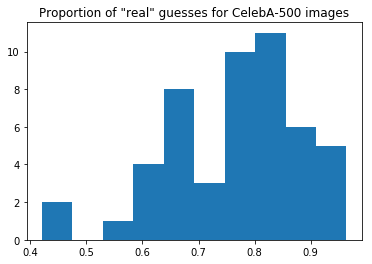

623


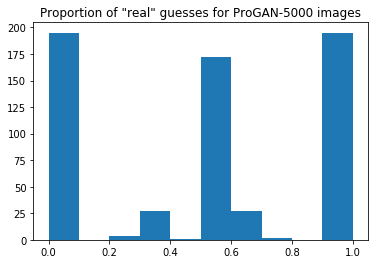

2233


In [6]:
#[(no,yes) for k,[no,yes] in img_votes['celeba500'].items() if yes+no>1]
real_yeses = [(yes/(yes+no)) for k,[no,yes] in img_votes['celeba500'].items() if yes+no>1]
plt.hist(real_yeses)
plt.title('Proportion of "real" guesses for CelebA-500 images')
plt.show()

real_yeses = [(yes/(yes+no)) for k,[no,yes] in img_votes['progan5000'].items() if yes+no>=2]
print(len(real_yeses))
plt.hist(real_yeses)
plt.title('Proportion of "real" guesses for ProGAN-5000 images')
plt.show()

print(len(img_votes['progan5000']))

In [28]:
# Now let's split up the data...
celeba_labeled = set(img_counts['celeba500'].keys())
progan_labeled = set(img_counts['progan5000'].keys())
print(len(celeba_labeled), len(progan_labeled))

celeba_all = set(os.listdir('./celeba_imgs/celeba500'))
celeba_unlabeled = celeba_all - celeba_labeled
print(len(celeba_all), len(celeba_unlabeled))

progan_all = set(os.listdir('./progan5000'))
progan_unlabeled = progan_all - progan_labeled
print(len(progan_all), len(progan_unlabeled))

66 2233
800 734
5000 2767


In [35]:
#%ls celeba_imgs/celeba500/
#%ls progan5000/
for x in celeba_labeled:
    os.symlink('./celeba_imgs/celeba500/' + x, 'imgs_by_label/celeba_labeled/celeba_labeled_imgs/' + x)

So of the real CelebA images, we have labels for 50 of them (plus an additional 16 with 1 label each). There are ~300 labels per image (!). The proportion of "this is real" labels per image varies widely and is somewhat bimodal with peaks around .65 and .85, but is consistently > 0.5.

For ProGAN-5000, we have 2233 labeled points, but most of them (~1500) are only labeled once, with most of the rest only labeled 2 or 3 times. The labels are 0 or 1 with roughly equal probability. The distribution of "real" proportions is very close to uniform over images, so it remains unknown if human raters prefer any of the ProGAN images over others, or if all of them are roughly equally likely to get a "real" or "fake" rating.

Now for pulling features out of the images themselves...

:

In [6]:
inception_net = models.inception_v3(pretrained=True, transform_input=True)

In [7]:
inception_transforms = transforms.Compose([
            transforms.Resize(299),
            #transforms.CenterCrop(constants.INPUT_SIZE),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

In [8]:
progan_images = datasets.ImageFolder('progan_imgs/', inception_transforms)
progan_images

Dataset ImageFolder
    Number of datapoints: 300
    Root location: progan_imgs/

In [9]:
celeba_images = datasets.ImageFolder('celeba_imgs/', inception_transforms)
celeba_images

Dataset ImageFolder
    Number of datapoints: 800
    Root location: celeba_imgs/

In [10]:
progan_loader = torch.utils.data.DataLoader(
        progan_images, batch_size=1, shuffle=True, num_workers=1)

celeba_loader = torch.utils.data.DataLoader(
        celeba_images, batch_size=1, shuffle=True, num_workers=1)

In [11]:
#If this hacky globals-based code isn't going well, see 
#https://www.kaggle.com/sironghuang/understanding-pytorch-hooks
#for an OOP alternative

layers_to_grab = [inception_net.Conv2d_1a_3x3, inception_net.Conv2d_2b_3x3,
                 inception_net.Conv2d_3b_1x1, inception_net.Mixed_5d, inception_net.Mixed_6e,
                 inception_net.Mixed_7c, inception_net.fc]

layer_features = [None for i in range(len(layers_to_grab))]

def hook_fn(self, inp, out, layer_index):
    global layer_features
    print(layer_index, inp[0].shape, out.shape)
    
    num_channels = out.shape[1]
    if len(out.shape) > 2:
        #Warning: this will break for batch sizes > 1
        cur_features = out.squeeze().permute(1,2,0).reshape(-1, num_channels)
    else:
        cur_features = out
    
    if layer_features[layer_index] is None:
        layer_features[layer_index] = cur_features
    else:
        layer_features[layer_index] = torch.cat((layer_features[layer_index], cur_features))

def hook_fn_i(i):
    return lambda self, inp, out: hook_fn(self, inp, out, i)

for i, layer in enumerate(layers_to_grab):
    layer.register_forward_hook(hook_fn_i(i))


torch.Size([1, 3, 299, 299]) tensor([0])


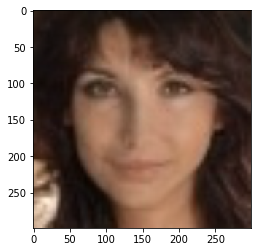

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-28.9801, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


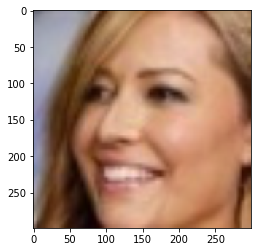

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-30.6820, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


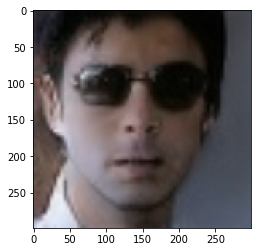

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-29.0584, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


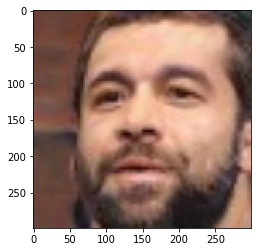

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-28.9778, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


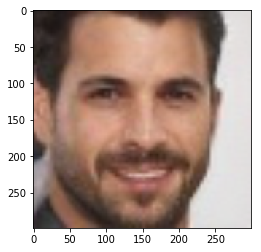

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-27.4999, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


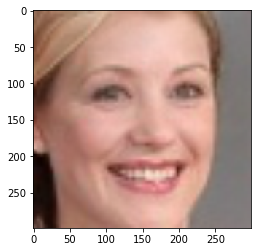

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-30.2947, grad_fn=<SumBackward0>)
torch.Size([1, 3, 299, 299]) tensor([0])


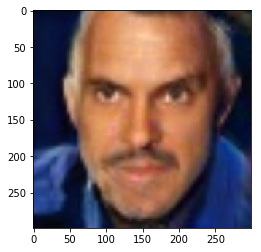

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-29.9491, grad_fn=<SumBackward0>)


In [17]:
inception_net.eval()

for x,y in islice(progan_loader,7):
    print(x.shape, y)
    plt.imshow((x).squeeze().permute(1, 2, 0))
    plt.show()
    out = inception_net(x)
    print(out.sum())

reference_layer_features = layer_features

In [18]:
[x.shape for x in reference_layer_features]

[torch.Size([310814, 32]),
 torch.Size([302526, 64]),
 torch.Size([74606, 80]),
 torch.Size([17150, 288]),
 torch.Size([4046, 768]),
 torch.Size([896, 2048]),
 torch.Size([14, 1000])]

In [45]:
inception_net2 = models.inception_v3(pretrained=True, transform_input=True)
inception_net.eval()
pass

In [46]:
layers_to_grab = [inception_net2.Conv2d_1a_3x3, inception_net2.Conv2d_2b_3x3,
                 inception_net2.Conv2d_3b_1x1, inception_net2.Mixed_5d, inception_net2.Mixed_6e,
                 inception_net2.Mixed_7c, inception_net2.fc]

layer_features = [None for i in range(len(layers_to_grab))]

def hook_fn(self, inp, out, layer_index):
    global layer_features
    print(layer_index, inp[0].shape, out.shape)
    
    num_channels = out.shape[1]
    if len(out.shape) > 2:
        cur_features = out.squeeze().permute(1,2,0)
    else:
        cur_features = out
    
    if layer_features[layer_index] is None:
        layer_features[layer_index] = cur_features
    else:
        layer_features[layer_index] = torch.cat((layer_features[layer_index], cur_features))

def hook_fn_i(i):
    return lambda self, inp, out: hook_fn(self, inp, out, i)

for i, layer in enumerate(layers_to_grab):
    layer.register_forward_hook(hook_fn_i(i))


torch.Size([1, 3, 299, 299]) tensor([0])


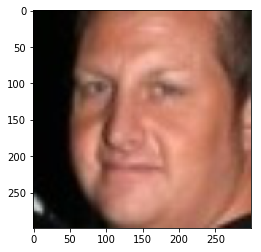

0 torch.Size([1, 3, 299, 299]) torch.Size([1, 32, 149, 149])
1 torch.Size([1, 32, 147, 147]) torch.Size([1, 64, 147, 147])
2 torch.Size([1, 64, 73, 73]) torch.Size([1, 80, 73, 73])
3 torch.Size([1, 288, 35, 35]) torch.Size([1, 288, 35, 35])
4 torch.Size([1, 768, 17, 17]) torch.Size([1, 768, 17, 17])
5 torch.Size([1, 2048, 8, 8]) torch.Size([1, 2048, 8, 8])
6 torch.Size([1, 2048]) torch.Size([1, 1000])
tensor(-34.0035, grad_fn=<SumBackward0>)


In [47]:
# Now using the ProGAN images for reference, find the nearest-neighbor distances to a CelebA image
# This is not how the experiments will work, but it'll get the math going

for x,y in islice(celeba_loader,1):
    print(x.shape, y)
    plt.imshow((x).squeeze().permute(1, 2, 0))
    plt.show()
    out = inception_net(x)
    print(out.sum())

In [50]:
rlf = reference_layer_features
[x.shape for x in rlf]

#In the reference set, for each layer, we don't care which image each of the C-dimensional vectors came from.
#So for layer l, we'll have N*H*W C-dimensional vectors.

#However, in the set of images we're actually featurizing, we DO care which image things come from.
#So we'll want to track the activations of the images as a NxHxWxC vector - or as Nx(H*W)xC, since we're
#averaging the nearest-neighbor distances anyways and therefore don't care about the H/W positions

[torch.Size([310814, 32]),
 torch.Size([302526, 64]),
 torch.Size([74606, 80]),
 torch.Size([17150, 288]),
 torch.Size([4046, 768]),
 torch.Size([896, 2048]),
 torch.Size([14, 1000])]

In [ ]:
from random import shuffle
#shuffle(rlf[0])
for i,layer in enumerate(layer_features):
    if i > 0: break
        
    print("Starting layer {}".format(i))
    print(layer.shape)
    #TODO: Now for each of the HxW C-dimensional vectors in each layer, find the closest C-dimensional
    #reference vector and make that scalar distance the entry of the results. 
    #layer.reshape(-1,layer.shape[2]) * rlf[i] #Maybe just do this, but copy each vector N times?
    
    
    #layer is HxWxC
    #rlf[i] is NxC
    H,W,C = layer.shape
    N,_ = rlf[i].shape
    
    x = layer.reshape(H*W, 1, C)
    cur_refs = rlf[i].reshape(1, N, C)
    
    diffs = x - cur_refs
    assert(diffs.shape == (H*W, N, C))
    print("Took differences of image and rlf")
    
    dists = torch.sqrt(torch.sum(diffs**2), dim=2)
    assert(dists.shape == (H*W, N))
    
    min_dists = torch.min(dists, dim=1)
    assert(min_dists.shape == (H*W))
    
    continue
    
    
    distances = []
    for row in layer:
        for entry in row:
            #print(entry.shape)
            
            all_distances = torch.sqrt(torch.sum((rlf[i][:15] - entry)**2, dim=1))
            print(all_distances.shape)
            least_distance = torch.min(all_distances).detach()
            least_distances.append(least_distance)
            
            #least_distance2 = 1e30
            #for ref_vec in rlf[i][:15]:
            #    #print(ref_vec.sum())
            #    dist = torch.sqrt(torch.sum((entry - ref_vec)**2))
            #    if dist < least_distance2: least_distance2 = dist
            #print("least distance is {}".format(least_distance))
            #distances.append(least_distance)
            #least_distance2 = least_distance2.detach()
            #assert least_distance == least_distance2
            
    


torch.Size([149, 149, 32])


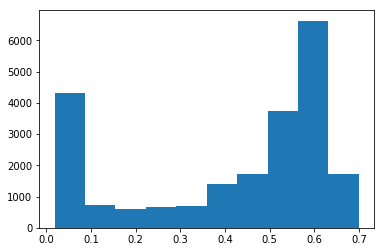

In [75]:
distances = [d.detach() for d in distances]
plt.hist(distances)
plt.show()

In [80]:
distances

[]

In [1]:
from random import shuffle
#shuffle(rlf[0])
for i,layer in enumerate(layer_features):
    if i > 0: break
        
    print("Starting layer {}".format(i))
    print(layer.shape)
    #TODO: Now for each of the HxW C-dimensional vectors in each layer, find the closest C-dimensional
    #reference vector and make that scalar distance the entry of the results. 
    #layer.reshape(-1,layer.shape[2]) * rlf[i] #Maybe just do this, but copy each vector N times?
    
    
    #layer is HxWxC
    #rlf[i] is NxC
    H,W,C = layer.shape
    N,_ = rlf[i].shape
    
    x = layer.reshape(H*W, 1, C)
    cur_refs = rlf[i].reshape(1, N, C)
    
    diffs = x - cur_refs
    assert(diffs.shape == (H*W, N, C))
    print("Took differences of image and rlf")
    
    dists = torch.sqrt(torch.sum(diffs**2), dim=2)
    assert(dists.shape == (H*W, N))
    print("Got distances from differences")
    
    min_dists = torch.min(dists, dim=1)
    assert(min_dists.shape == (H*W))
    print("Got min distances")
    
    print("Finished layer {}".format(i))
    
    continue
    
    
    distances = []
    for row in layer:
        for entry in row:
            #print(entry.shape)
            
            all_distances = torch.sqrt(torch.sum((rlf[i][:15] - entry)**2, dim=1))
            print(all_distances.shape)
            least_distance = torch.min(all_distances).detach()
            least_distances.append(least_distance)
            
            #least_distance2 = 1e30
            #for ref_vec in rlf[i][:15]:
            #    #print(ref_vec.sum())
            #    dist = torch.sqrt(torch.sum((entry - ref_vec)**2))
            #    if dist < least_distance2: least_distance2 = dist
            #print("least distance is {}".format(least_distance))
            #distances.append(least_distance)
            #least_distance2 = least_distance2.detach()
            #assert least_distance == least_distance2
            
    


NameError: name 'layer_features' is not defined

NameError: name 'rlf' is not defined